# Without Obstacles


Episode 50/2000 completed with cumulative reward: 1680
Episode 100/2000 completed with cumulative reward: 1320
Episode 150/2000 completed with cumulative reward: 780
Episode 200/2000 completed with cumulative reward: 1620
Episode 250/2000 completed with cumulative reward: 1860
Episode 300/2000 completed with cumulative reward: 1200
Episode 350/2000 completed with cumulative reward: 1860
Episode 400/2000 completed with cumulative reward: 1740
Episode 450/2000 completed with cumulative reward: 1320
Episode 500/2000 completed with cumulative reward: 1980
Episode 550/2000 completed with cumulative reward: 1620
Episode 600/2000 completed with cumulative reward: 1560
Episode 650/2000 completed with cumulative reward: 1560
Episode 700/2000 completed with cumulative reward: 1500
Episode 750/2000 completed with cumulative reward: 1080
Episode 800/2000 completed with cumulative reward: 840
Episode 850/2000 completed with cumulative reward: 960
Episode 900/2000 completed with cumulative reward: 1

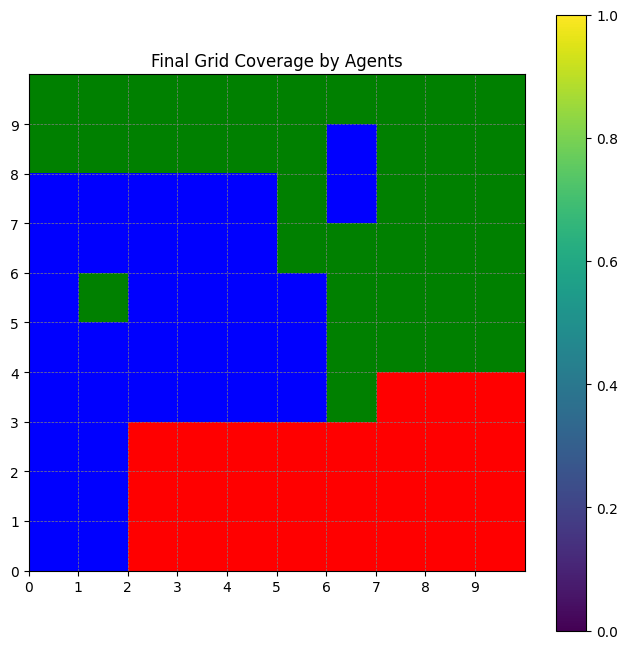

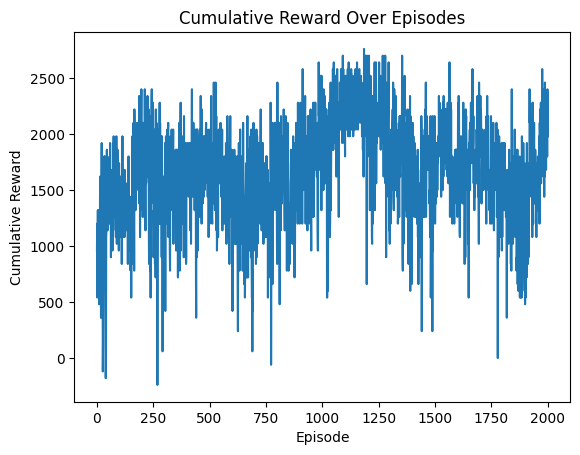

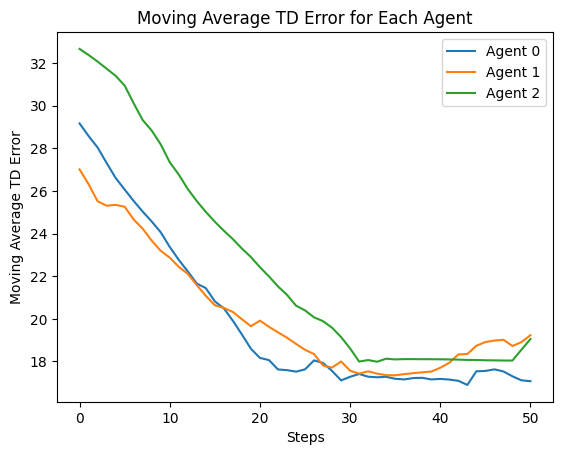

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Parameters and Constants
SEED = 42
GRID_SIZE = 10
NUM_AGENTS = 3
EPISODES = 2000
MAX_STEPS = 100
ALPHA = 0.1
GAMMA = 0.9
EPSILON = 0.3
EPSILON_DECAY = 0.99
EPSILON_MIN = 0.1
MOVING_AVERAGE_WINDOW = 50
REWARD_NEW_CELL = 50
REWARD_REVISIT = -10
agent_colors = ['red', 'blue', 'green']
actions = [(0, -1), (0, 1), (-1, 0), (1, 0)]
starting_positions = [(0, 0), (0, GRID_SIZE - 1), (GRID_SIZE - 1, 0)]

# Set seed for reproducibility
random.seed(SEED)
np.random.seed(SEED)

# Shared Q-table for exploration guidance
shared_q_table = {}

class Agent:
    def __init__(self, start_pos, agent_id):
        self.position = start_pos
        self.agent_id = agent_id
        self.q_values = {}  # Independent Q-table for each agent
        self.cumulative_reward = 0
        self.covered_cells = 0
        self.error_log = []

    def reset(self, start_pos):
        self.position = start_pos
        self.cumulative_reward = 0
        self.covered_cells = 0
        self.error_log.clear()

    def choose_action(self, visited_cells):
        if random.uniform(0, 1) < EPSILON:
            return random.randint(0, 3)

        state_key = str(self.position)
        if state_key not in self.q_values:
            self.q_values[state_key] = np.zeros(4)

        # Use a combination of personal Q-values and shared Q-values
        combined_q_values = self.q_values[state_key].copy()
        if state_key in shared_q_table:
            combined_q_values += 0.5 * shared_q_table[state_key]  # Blend with shared Q-values

        return np.argmax(combined_q_values)

    def update_q(self, state, action, reward, next_state):
        state_key, next_state_key = str(state), str(next_state)
        if state_key not in self.q_values:
            self.q_values[state_key] = np.zeros(4)
        if next_state_key not in self.q_values:
            self.q_values[next_state_key] = np.zeros(4)

        best_next_action = np.argmax(self.q_values[next_state_key])
        target = reward + GAMMA * self.q_values[next_state_key][best_next_action]
        td_error = target - self.q_values[state_key][action]
        self.q_values[state_key][action] += ALPHA * td_error
        self.error_log.append(abs(td_error))

        # Update shared Q-table with average Q-values to promote exploration
        if state_key not in shared_q_table:
            shared_q_table[state_key] = np.zeros(4)
        shared_q_table[state_key][action] += ALPHA * td_error * 0.5  # Smaller step to avoid overpowering agent independence

def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

# Initialize agents and run training
visited_by_agent = np.full((GRID_SIZE, GRID_SIZE), -1)
cumulative_rewards = []
agents = [Agent(pos, i) for i, pos in enumerate(starting_positions)]

for episode in range(EPISODES):
    visited_cells = np.zeros((GRID_SIZE, GRID_SIZE), dtype=int)
    for agent in agents:
        agent.reset(agent.position)

    episode_cumulative_reward = 0
    for step in range(MAX_STEPS):
        for agent in agents:
            state = agent.position
            action = agent.choose_action(visited_cells)
            dx, dy = actions[action]
            new_x, new_y = max(0, min(GRID_SIZE - 1, state[0] + dx)), max(0, min(GRID_SIZE - 1, state[1] + dy))
            next_state = (new_x, new_y)
            reward = REWARD_NEW_CELL if visited_cells[new_x, new_y] == 0 else REWARD_REVISIT
            visited_cells[new_x, new_y] = 1 if reward == REWARD_NEW_CELL else visited_cells[new_x, new_y]
            if reward == REWARD_NEW_CELL:
                agent.covered_cells += 1
                visited_by_agent[new_x, new_y] = agent.agent_id
            agent.update_q(state, action, reward, next_state)
            agent.position = next_state
            agent.cumulative_reward += reward
            episode_cumulative_reward += reward
        if EPSILON > EPSILON_MIN:
            EPSILON *= EPSILON_DECAY
    cumulative_rewards.append(episode_cumulative_reward)
    if (episode + 1) % 50 == 0:
        print(f"Episode {episode + 1}/{EPISODES} completed with cumulative reward: {episode_cumulative_reward}")

# Print final results
print("\nFinal Results After Training:")
for agent in agents:
    print(f"Agent {agent.agent_id}: Total Cumulative Reward: {agent.cumulative_reward}, Total Cells Covered: {agent.covered_cells}")

# Visualization 1: Final grid coverage
plt.figure(figsize=(8, 8))
final_grid = np.zeros((GRID_SIZE, GRID_SIZE, 3))
for x in range(GRID_SIZE):
    for y in range(GRID_SIZE):
        if visited_by_agent[x, y] != -1:
            agent_id = visited_by_agent[x, y]
            final_grid[x, y] = mcolors.to_rgb(agent_colors[agent_id])
plt.imshow(final_grid, extent=[0, GRID_SIZE, 0, GRID_SIZE])
plt.colorbar()
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.xticks(range(GRID_SIZE))
plt.yticks(range(GRID_SIZE))
plt.title("Final Grid Coverage by Agents")
plt.show()

# Visualization 2: Cumulative reward over episodes
plt.figure()
plt.plot(range(1, EPISODES + 1), cumulative_rewards)
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.title("Cumulative Reward Over Episodes")
plt.show()

# Visualization 3: Moving average TD error for each agent
plt.figure()
for agent in agents:
    moving_avg_error = moving_average(agent.error_log, MOVING_AVERAGE_WINDOW)
    plt.plot(moving_avg_error, label=f"Agent {agent.agent_id}")
plt.xlabel("Steps")
plt.ylabel("Moving Average TD Error")
plt.title("Moving Average TD Error for Each Agent")
plt.legend()
plt.show()
